In [71]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Install Prerequisites
# import sys
# !{sys.executable} -m pip install scikit-learn scikit-surprise
# !pip install git+https://github.com/gbolmier/funk-svd

# Exploratory Data Analysis
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
import random
from time import time
import cufflinks as cf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Models
from surprise import Reader, Dataset
from surprise import SVD,SVDpp, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")
pd.set_option('display.max_columns', 37)



In [72]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


In [73]:
movies_df =  pd.read_csv('movies.csv', index_col='movieId')
imdb_df =  pd.read_csv('imdb_data.csv', index_col='movieId')
links_df =  pd.read_csv('links.csv', index_col='movieId')
genome_scores =  pd.read_csv('genome_scores.csv', index_col='movieId')
genome_tags =  pd.read_csv('genome_tags.csv', index_col='tagId')
tags =  pd.read_csv('tags.csv')
print(movies_df.shape, imdb_df.shape, links_df.shape, genome_scores.shape, genome_tags.shape)

(62423, 2) (27278, 5) (62423, 2) (15584448, 2) (1128, 1)


## Data Preprocessing

In [74]:
# Load the 100k dataset
# Load the 100k dataset
train_df.drop('timestamp', axis=1, inplace=True)
train_subset = train_df[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)



For the collaborative filtering model we are going to use the data from the train_csv file. In that file we are particularly interested in the userid, movieid and the rating. The timestamp will be dropped because it has a strong positive correlation with movieid and therefore dropping it won't affect the model as much. Secondly,we are going to use algorithms from the surprise library and it does not support implicit rating data (timestamp is implicit). Timestamp will also be dropped as . We are using the first 1000000 rows because our data is alot and it takes more computational power and time. To gather information about how the model is performing we use 1000000 thereafter we only train the best performing model with the best performing model. 

# Building the models 
In this section we are going to build both collaborative and content-based filtering recommender systems. We begin with collaborative filtering which aims to predict the rating while the content-based  algorithm aims to predict the movie name. 



# Collaborative filtering models 

Collaborative filtering algorithm aims to make automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating).

######### insert a movie recomnder  picture 

The Collaborative Filtering (CF) technique can be classified into following categories namely: Memory based and model based. The **memory based** CF method uses user to user and item to item correlations based on rating behavior to predict ratings and recommend items for the users in future.  Unlike Memory-Based CF,**Model-based CF** does not use the whole dataset to compute predictions for real data. There are various model-based CF algorithms including Bayesian Networks, Clustering Models, and Latent Semantic Models such as Singular Value Decomposition (SVD), Principal Component Analysis (PCA) and Probabilistic Matrix Factorization for dimensionality reduction
of rating matrix. In this notebook we focused on **model-based-CF** 

The main advantage of this algorithm is that it doesn’t need anything else except users’ historical preference on a set of items.Such data is readily and easier to collect. Making it a cheaper algorithm to use for quick results on this dataset but costly to companies as large recommendation services tend to have far more users than items in their databases. Their ratings also have to be constantly tracked to provide accurate predictions. Collaborative filtering also has a cold start problem where it can often become very difficult to make recommendations for users who have few or no ratings captured. However as time increases, systems which make use of collaborative filtering techniques get progressively better as they passively acquire richer rating data. 

## Our approach to Collaborative filtering models 

For collaborative filtering we are using eleven algorithms from the Surprise library.Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. Explicit rating data is data  where the user directly provides ratings about an item(or movie in our case). The choice to use the surprise library meant that we had to drop the timestamp column. 

### Basic algorithms
***NormalPredictor:*** This algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal.

***BaselineOnly:*** This algorithm predicts the baseline estimate for a given user and item.

### k-NN algorithms
kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors.For example, in our data there is user id, movieid and ratings. The KNN will try to find the k item that has the most similar user engagement vectors.

***KNNBasic:*** This is a basic collaborative filtering algorithm.

***KNNWithMeans:*** This is a basic collaborative filtering algorithm, taking into account the mean ratings of each user.

***KNNWithZScore:*** This is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

***KNNBaseline:*** is a basic collaborative filtering algorithm taking into account a baseline rating.

### Matrix Factorization-based algorithms
The Matrix Factorization techniques are usually more effective because they allow use to discover the latent features underlying the interactions between
users and items. Matrix Factorization is simply a mathematical tool for playing around with matrices, and is therefore applicable in many domains where one would like to find out something hidden under the data. SVD and PCA are well known Matrix Factorization models for identifying latent factors in the field of Information Retrieval to deal with Collaborative Filtering challenges(2014). 

***SVD:*** This algorithm is equivalent to Probabilistic Matrix Factorization ( which makes use of data provided by users with similar preferences to offer recommendations to a particular user).

***SVDpp:*** This algorithm is an extension of SVD that takes into account implicit ratings.

***NMF:*** This is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar to SVD.

***SlopeOne:*** This is a straightforward implementation of the SlopeOne algorithm.

***Co Clustering:*** is a collaborative filtering algorithm based on co-clustering.




In [75]:
#Now let us implement the above mentioned algorithms  to train and test models 
algo = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), 
                  KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

#Read 10000 dataset
data2 = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']].head(10000), Reader())

#Implementing algorithm for RMSE
algo_rmse=[]
for a in algo:
    
    cross_valid=cross_validate(a, data2, measures=['RMSE'], cv = 3)
    output=pd.DataFrame.from_dict(cross_valid).mean(axis=0)
    output=output.append(pd.Series([str(a).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    algo_rmse.append(output)

algo_rmse
surprise_results = pd.DataFrame(algo_rmse).set_index('Algorithm').sort_values('test_rmse')
surprise_results



Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.045370,0.561593,0.021106
SVD,1.047348,0.385430,0.019562
BaselineOnly,1.048290,0.025119,0.014255
KNNBaseline,1.048868,1.039796,0.019289
KNNBasic,1.076947,0.979373,0.021384
KNNWithZScore,1.099217,1.272994,0.020932
SlopeOne,1.102634,0.258356,0.018988
KNNWithMeans,1.104793,1.081202,0.021521
CoClustering,1.107829,0.729987,0.013329


As you can see from above the SVDPP, KNN baseline and SVD are the best performing with the least training and testing time as well as rmse. We prefered to use rmse as our accuracy measurement metric as  The following section will look at these algorithms performance with hyperparamenters included to improve the model perfomance. We selected the three best perfoming models. Please note that we use the cross validation algorithm to help estimate how accurately a predictive model will perform in practice and decrease chances of overfitting.  

In [ ]:
surprise_results[]

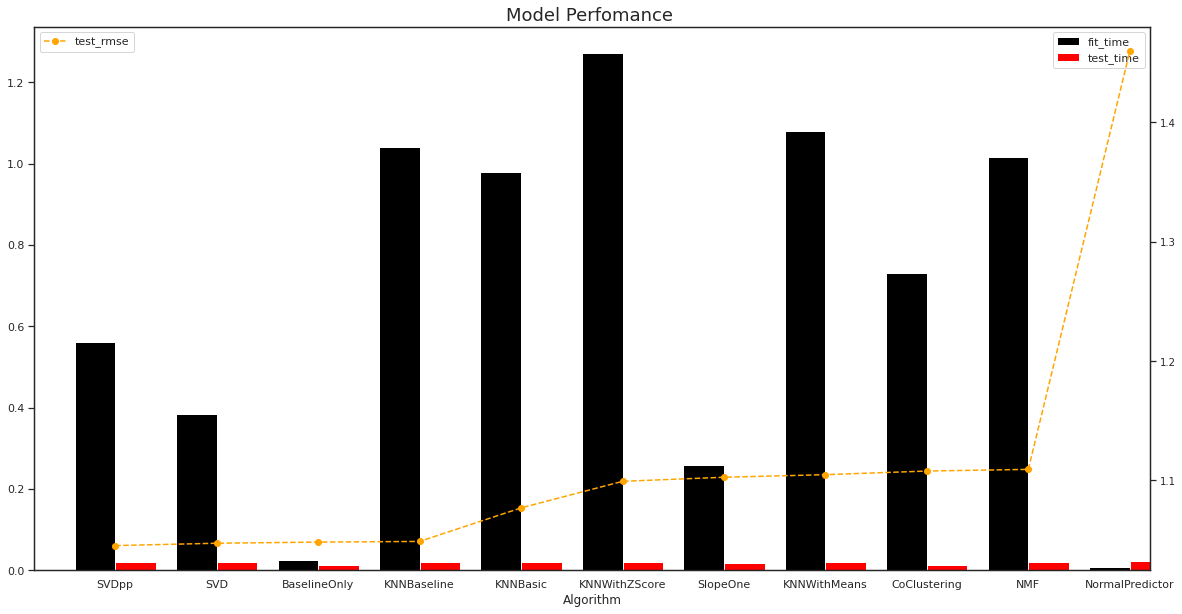

In [76]:
# Now lets plot a graph to show the results 
width=.8
surprise_results[['fit_time','test_time']].plot(kind='bar', width = width,figsize=(20,10), color = ['black','red','orange'] ) #to plot the bar graph
surprise_results['test_rmse'].plot(secondary_y=True, color='orange', linestyle='--', marker='o')

ax = plt.gca()
plt.xlim([-width, len(surprise_results['test_time'])-width])
ax.set_title('Model Perfomance ',fontsize=18)
plt.xticks(size = 10, rotation=90)
plt.yticks(size = 10)
plt.legend(surprise_results[['test_rmse','fit_time','test_time']])
plt.show()

From the above graph we can see that the SVD,SVDpp and the KNNBaseline are the top three performing algorithms ( using RMSE as the unit of measurement). SVDpp and KNNBaseline scored the same RMSE but SVDpp takes less time to train and test. Due to this, we conclude that we will only try to improve the SVDpp algorithm. Baseline only model is intriguing as it has the lowest train and test time while its RMSE is significantly low(close to  KNNBaseline). As a result we decided to try to improve it because if it can be better it would be the cheapest solution for our client (DSTV). 



## Model Improvement

## SVD  model
The SVD model is the first model we will try to improve as it has the lowest RMSE score.

In [87]:
#SVD model
svd=SVD(n_epochs = 30, n_factors = 400, init_std_dev = 0.005, random_state=42)

#Fitting the model
svd.fit(trainset)

# Making prediction on the validation dataset
test_pred= svd.test(testset)

#Evaluating model performance
rsme_svd = accuracy.rmse(test_pred,
                             verbose=True)

RMSE: 0.9739


In [88]:
#Predicting the rating for each user and movie
ratings=[]
for x,y in test_df.itertuples(index=False):
    output=svd.predict(x,y)
    ratings.append(output)
    
output_df=pd.DataFrame(ratings)[['uid','iid','est']]
output_df['ID']=output_df['uid'].astype(str) + '_' + output_df['iid'].astype(str)
output_df=output_df[['ID','est']]
output_df.head()

,ID,est
0,1_2011,3.496114
1,1_4144,3.882320
2,1_5767,3.535007
3,1_6711,3.934648
4,1_7318,2.673480


In [89]:
#Creating the "results" dataframe and convert to csv
results = pd.DataFrame({"Id":output_df['ID'],"rating": output_df['est']})
results.to_csv("SVD1.csv", index=False)

## SDVpp
The next model we will try to improve is the SVDpp model as it had the second best RMSE score.

In [90]:
#SVDpp model
svdpp=SVDpp(n_epochs = 30, n_factors = 400, init_std_dev = 0.05, random_state=42)

#Fitting the model
svdpp.fit(trainset)

# Making prediction on the validation dataset
test_pred= svdpp.test(testset)

#Evaluating model performance
rsme_svdpp = accuracy.rmse(test_pred,
                             verbose=True)

RMSE: 0.9912


In [91]:
#Predicting the rating for each user and movie
ratings=[]
for x,y in test_df.itertuples(index=False):
    output=svdpp.predict(x,y)
    ratings.append(output)
    
output_df=pd.DataFrame(ratings)[['uid','iid','est']] # results into a table 
output_df['ID']=output_df['uid'].astype(str) + '_' + output_df['iid'].astype(str)
output_df=output_df[['ID','est']]
output_df.head()

,ID,est
0,1_2011,3.529787
1,1_4144,3.768790
2,1_5767,3.535007
3,1_6711,3.800580
4,1_7318,2.977684


In [92]:
#Creating the "results" dataframe and convert to csv for kaggle submission
results = pd.DataFrame({"Id":output_df['ID'],"rating": output_df['est']})
results.to_csv("SVDpp.csv", index=False)

## Baseline Only Model
The baseline model will be hypertuned with the hopw that it performs better than SDV as it has a very low test and train time. If the Baseline performs well we will recomend it to our client as it will save on running costs while producing optimal results.

In [93]:
#BaselineOnly model
bsl_options = {'method': 'sgd','n_epochs': 30}
blo=BaselineOnly(bsl_options=bsl_options)

#Fitting the model
blo.fit(trainset)

# Making prediction on the validation dataset
test_pred= blo.test(testset)

#Evaluating model performance
rsme_baseline = accuracy.rmse(test_pred,
                             verbose=True)

Estimating biases using sgd...
RMSE: 0.9739


In [94]:
#Predicting the rating for each user and movie
ratings=[]
for x,y in test_df.itertuples(index=False):
    output=blo.predict(x,y)
    ratings.append(output)
    
output_df=pd.DataFrame(ratings)[['uid','iid','est']]
output_df['ID']=output_df['uid'].astype(str) + '_' + output_df['iid'].astype(str)
output_df=output_df[['ID','est']]
output_df.head()

,ID,est
0,1_2011,3.496168
1,1_4144,3.882676
2,1_5767,3.535007
3,1_6711,3.934899
4,1_7318,2.672662


In [95]:
#Creating the "results" dataframe and convert to csv
results = pd.DataFrame({"Id":output_df['ID'],"rating": output_df['est']})
results.to_csv("blo.csv", index=False)

Now lets compare results with graph showing the RMSE improvement.

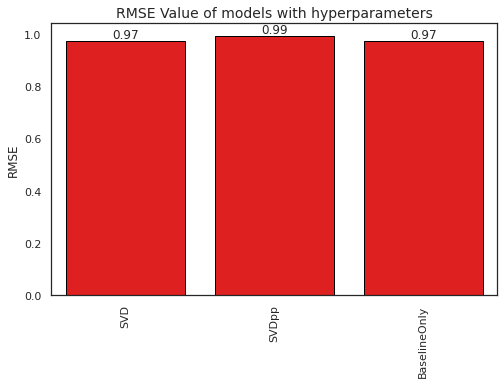

In [96]:
# Compare RMSE values between models that have been inproved with hypararameters 
fig,axis = plt.subplots(figsize=(8, 5))
rmse_x = ['SVD','SVDpp','BaselineOnly']
rmse_y = [rsme_svd,rsme_svdpp,rsme_baseline]
ax = sns.barplot(x=rmse_x, y=rmse_y,color='red',edgecolor='black')
plt.title('RMSE Value of models with hyperparameters',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),2), fontsize=12, ha="center", va='bottom')
    
plt.show()

In [97]:
#Creating the "results" dataframe and convert to csv file for kaggle submission
results = pd.DataFrame({"Id":output_df['ID'],"rating": output_df['est']})
results.to_csv("blo.csv", index=False)

### Hyperparameter Tuning

Hyperparameter tuning is the process of determining the right combination of hyperparameters that allows the model to maximize model performance. Setting the correct combination of hyperparameters is the only way to extract the maximum performance out of models.

We decided to hypertune the SVD algorithm model, which was the best performing amongst the top three algorithm (since it had the lowest RMSE value).

In [98]:
param_grid = {'n_epochs':[40], #[30,40,50],
              'n_factors':[400], #[100,200,300,400],
              'init_std_dev':[0.005], #[0.001,0.005,0.05,0.1],
              'random_state':[42]} 
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], param_grid=param_grid, n_jobs=-1)
grid_SVD.fit(data)
print('***Best score:***')
print(grid_SVD.best_score['rmse'])
print('***Best parameters:***')
print(grid_SVD.best_params['rmse'])

***Best score:***
0.9670327595612163
***Best parameters:***
{'n_epochs': 40, 'n_factors': 400, 'init_std_dev': 0.005, 'random_state': 42}


Now that we have discoverd the optimal values for our hyperparameters we input those in our model and try to test the model on all the data available for a final submission on kaggle.

## Final Kaggle submission

In [ ]:
# Train model on whole dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42, verbose=True)
svd.fit(trainset)

# Create Kaggle submission file
predictions = []
for i, row in test_df.iterrows():
    x = (svd.predict(row.userId, row.movieId))
    pred = x[3]
    predictions.append(pred)
test_df['Id'] = test_df['userId'].map(str) +'_'+ test_df['movieId'].map(str)
results = pd.DataFrame({"Id":test_df['Id'],"rating": predictions})
results.to_csv("SVD_FINAL.csv", index=False)

Processing epoch 0
Processing epoch 1
Processing epoch 2



# Conclusion
The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize isn't a surprising choice for collaborative based recomendation. After hyperparameter tuning the SVD pereformed the best with a kaggle score of 0.7. On top of that it has a low train and test time. This makes it an ideal solution for our client. 



References 

https://arxiv.org/ftp/arxiv/papers/1503/1503.07475.pdf

https://www.xpertup.com/downloads/movie-recommender-system/